In [2]:
from gymnasium import Env
from gymnasium.spaces import Box, Dict, Discrete
from ray.rllib.utils.spaces.repeated import Repeated
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import networkx as nx
from copy import copy

In [3]:
class Architecture:
    def __init__(self):
        self.c_capacity, self.s_capacity = 50, 2
        self.weights = [0.0125, 0.0010, 0.0200, 0.5000] # REVIEW
        self.lifetime = {0: 1, 1: 2, 2: 3, 3: 10}   # REVIEW
        self.max_actions = 10
        self.num_c = 2
        self.num_s = 6
        self.max_actions = 10
        self.min_free_space = 0.2
        self.space_flag = -1

        self.data_types = []
        self.data_allocation = []
        self.data_times = []

        self.data = {}
        self.devices = {}
        self.latencies = {}
        self.max_latencies = {}

        self.action_device = []
        self.action_type = []

        for j in (range(len(self.weights))):
            self.data[j] = {}
            for i in range(self.num_s+self.num_c):
                self.data[j][i] = 0
                self.devices[i] = {0: 0, 1: 0, 2: 0, 3: 0}
                self.latencies[i] = {}
                self.max_latencies[i] = {}

        for i in self.latencies.keys():
            for j in self.latencies.keys():
                self.latencies[i][j] = 0
                self.max_latencies[i][j] = 0

        randomized = list(self.devices.keys())
        random.shuffle(randomized)
        bound = round(len(self.devices)/4)
        self.clusters = {
            0: randomized[:bound],
            1: randomized[bound:bound*2],
            2: randomized[bound*2:bound*3],
            3: randomized[bound*3:]
        }
        self.visualization()

    def construct_dictionaries(self):
        for i in self.data:
            for j in self.data[i]:
                self.data[i][j] = 0
        for i in self.devices:
            for j in self.devices[i]:
                self.devices[i][j] = 0
        for device, d_type in zip(self.data_allocation, self.data_types):
            self.data[d_type][device] += 1
            self.devices[device][d_type] += 1

    def update(self, data_type, device):
        self.data_types.append(data_type)
        self.data_allocation.append(device)
        self.data_times.append(0)
        self.devices[device][data_type] += 1
        self.data[data_type][device] += 1

    def heart_beat(self):
        deads = []
        for i in range(len(self.data_times)):
            self.data_times[i] += 1
            if self.data_times[i] == self.lifetime[self.data_types[i]]:
                deads.append(i)

        removed = 0
        for i in deads:
            self.devices[self.data_allocation[i-removed]][self.data_types[i-removed]] -= 1
            self.data[self.data_types[i-removed]][self.data_allocation[i-removed]] -= 1
            self.data_types.pop(i - removed)
            self.data_allocation.pop(i - removed)
            self.data_times.pop(i - removed)
            removed += 1

    def free_space(self):
        load = {}
        for i in range(self.num_c + self.num_s):
            if i < self.num_c:
                load[i] = (self.c_capacity - sum([a*b for a,b in zip(list(self.devices[i].values()), self.weights)]))/self.c_capacity
            else:
                load[i] = (self.s_capacity - sum([a*b for a,b in zip(list(self.devices[i].values()), self.weights)]))/self.s_capacity
            if load[i] <= self.min_free_space:
                self.space_flag = i
        return load

    def reduce_type(self, data_type):
        max_time = 0
        positions = []
        for i in range(len(self.data_allocation)):
            if self.data_types[i] == data_type:
                if self.data_times[i] > max_time:
                    max_time = self.data_times[i]
                    positions = []
                    positions.append(i)
                elif self.data_times[i] == max_time:
                    positions.append(i)

        removed = 0
        for i in positions:
            self.devices[self.data_allocation[i-removed]][self.data_types[i-removed]] -= 1
            self.data[self.data_types[i-removed]][self.data_allocation[i-removed]] -= 1
            self.data_times.pop(i - removed)
            self.data_types.pop(i - removed)
            self.data_allocation.pop(i -removed)
            removed += 1

    def check_quantity(self, data_type):
        if data_type != 3:
            if sum(list(self.data[data_type].values())) > 2*(self.num_s + self.num_c):
                self.reduce_type(data_type)
        else:
            if sum(list(self.data[data_type].values())) > 2*self.num_s:
                self.reduce_type(data_type)

    def visualization(self):
        keys = list(self.devices.keys())
        cs = keys[:self.num_c]
        ss = keys[self.num_c:]

        colors = []
        sizes = []

        graph = nx.Graph()

        colors.append('lightblue')
        sizes.append(1000)
        index = 0
        for i in range(len(cs)):
            if i != len(cs)-1:
                colors.append('lightblue')
                sizes.append(1000)
                graph.add_edge(cs[i],cs[i+1])
                graph.add_weighted_edges_from([(cs[i],cs[i+1],10)])
                for j in range(int(len(ss)/self.num_c)):
                    colors.append('orange')
                    sizes.append(100)
                    graph.add_edge(cs[i],ss[index])
                    graph.add_weighted_edges_from([(cs[i],ss[index],4)])
                    index += 1
            else:
                graph.add_edge(cs[i],cs[0])
                graph.add_weighted_edges_from([(cs[i],cs[0],10)])
                for j in range(int(len(ss)/self.num_c)+len(ss)%self.num_c):
                    graph.add_edge(cs[i],ss[index])
                    graph.add_weighted_edges_from([(cs[i],ss[index],4)])
                    colors.append('orange')
                    sizes.append(100)
                    index += 1

        pos = nx.spring_layout(graph)  # Position nodes using a spring layout algorithm
        # nx.draw(graph, pos, with_labels=True, node_size=sizes, node_color=colors, font_weight=12, font_color='black', edge_color='gray')
        edge_labels = nx.get_edge_attributes(graph, 'weight')
        # nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)

        # plt.title("Architecture:")
        # plt.axis('off')
        # plt.show()

        for u in graph.nodes:
            shortest_paths = nx.shortest_path_length(graph, source=u, weight='weight')
            for v, weight in shortest_paths.items():
                self.latencies[u][v] = weight

        max_latency = self.latencies[self.num_c][self.num_c+self.num_s-1]
        for i in self.max_latencies.keys():
            for j in self.max_latencies[i].keys():
                self.max_latencies[i][j] = max_latency

    def compute_total_latency(self):
        total_latency = 0
        for i in range(len(self.action_type)):
            total_latency += sum([a*b for a,b in zip(self.data[self.action_type[i]].values(), self.latencies[self.action_device[i]].values())])
        return total_latency

    def compute_normalized_latency(self):
        total_latency = 0
        max_latency = 0
        for i in range(len(self.action_type)):
            total_latency += sum([a*b for a,b in zip(self.data[self.action_type[i]].values(), self.latencies[self.action_device[i]].values())])
            max_latency += sum([a*b for a,b in zip(self.data[self.action_type[i]].values(), self.max_latencies[self.action_device[i]].values())])
        return total_latency/(max_latency+1)

    def rl_update(self, new_allocation):
        self.data_allocation = new_allocation
        self.construct_dictionaries()
        return self.free_space()

    def generate(self, operation):
        if operation == 0 or operation == 1 or operation == 2:
            for i in range(self.num_s + self.num_c):
                self.update(operation,i)
            self.check_quantity(operation)
        elif operation == 3:
            for i in range(self.num_c,(self.num_c + self.num_s)):
                self.update(operation,i)
            self.check_quantity(operation)
        else:
            device=random.sample(self.clusters[operation - 10],1)
            self.action_device.append(device[0])
            self.action_type.append(operation-10)
            difference = len(self.action_device) - self.max_actions
            if difference >= 0:
                for i in range(difference):
                    self.action_device.pop(0)
                    self.action_type.pop(0)

    def greedy_algorithm(self):
        if self.space_flag == -1:
            print("It's ok")
            allocation = []
            for i in self.data_types:
                allocation.append(random.sample(list(self.clusters[i]),1)[0])
            self.data_allocation = allocation
            self.construct_dictionaries()
        else:
            print("Problem")
            problematic_key = None
            for key, value in self.clusters.items():
                if self.space_flag in value:
                    problematic_key = key
                    break
            for i in range(self.num_c):
                self.clusters[problematic_key].append(i)
            self.space_flag = -1
            self.greedy_algorithm()

In [243]:
class AcesArchitectureEnv(Env):
    def __init__(self, maximum_data):
        self.architecture = Architecture()
        self.executions = [[0,1,2,10],
                           [0,1,2,11],
                           [0,1,2,12],
                           [0,1,2,3],
                           [0,1,2,10],
                           [0,1,2,11],
                           [0,1,2,12],
                           [0,1,2,3],
                           [0,1,2,13]]
        self.execution_index = 0
        self.num_devices = len(self.architecture.devices.keys())
        self.maximum_data = maximum_data

        self.weigths = self.architecture.weights
        self.allocation = self.architecture.data_allocation
        self.data_types = self.architecture.data_types
        self.free_space = list(self.architecture.free_space().values())
        self.last_calls_type = self.architecture.action_type
        self.last_calls_device = self.architecture.action_device

        self.observation_space = Dict({
            "weights": Box(low=0, high=1, shape=(4,), dtype=np.float32),
            "allocation": Box(low=-1, high=self.num_devices-1, shape=(maximum_data,), dtype=np.int32),
            # "allocation": Repeated(Discrete(self.num_devices),maximum_data),
            "data_type": Box(low=-1, high=3, shape=(maximum_data,), dtype=np.int32),
            # "data_type": Repeated(Discrete(4),maximum_data),
            "free_space": Box(low=-10, high=1, shape=(self.num_devices,), dtype=np.float32),
            "last_calls_type": Box(low=-1, high=13, shape=(10,), dtype=np.int32),
            # "last_calls_type": Repeated(Discrete(4,start=10),10),
            "last_calls_device": Box(low=-1, high=self.num_devices-1, shape=(10,), dtype=np.int32)
            # "last_calls_device": Repeated(Discrete(self.num_devices),10)
        })

        self.action_space = Box(low=0, high=self.num_devices-1, shape=(maximum_data,), dtype=np.int32)

        self.allocation_length = len(self.allocation)

        self.reward = 0

    def get_obs(self):

        return {
            "weights": np.array(self.weigths),
            "allocation": np.array(self.allocation),
            "data_type": np.array(self.data_types),
            "free_space": np.array(self.free_space),
            "last_calls_type": np.array(self.last_calls_type),
            "last_calls_device": np.array(self.last_calls_device)
        }

    def step(self,action):
        self.architecture.data_allocation = list(action[:self.allocation_length])
        self.allocation[:self.allocation_length] = list(action[:self.allocation_length])
        self.architecture.construct_dictionaries()
        normalized_latency = self.architecture.compute_normalized_latency()
        # normalized_latency = 0
        self.free_space = list(self.architecture.free_space().values())

        # flag = False
        # for i in self.free_space:
        #     if i <= self.architecture.min_free_space:
        #         flag = True
        #         break
        #
        # if flag:
        #     self.reward = -3
        # else:
        #     w1 = 2
        #     w2 = 1
        #     std = np.std(self.free_space)
        #     self.reward = w1*(1 - normalized_latency) + w2*(1-std)
        self.reward = (1 - normalized_latency) - 0.5

        done = True
        info = {}

        return self.get_obs(), self.reward, done, info

    def reset(self):
        if self.reward < -10:
            return self.get_obs()
        else:
            self.architecture.heart_beat()
            for execution in self.executions[self.execution_index]:
                self.architecture.generate(execution)
            self.allocation = self.architecture.data_allocation.copy()
            self.data_types = self.architecture.data_types.copy()
            self.allocation_length = len(self.allocation)
            for minus_one in range(self.maximum_data - len(self.allocation)):
                self.allocation.append(-1)
                self.data_types.append(-1)
            self.free_space = list(self.architecture.free_space().values())
            self.last_calls_type = self.architecture.action_type.copy()
            self.last_calls_device = self.architecture.action_device.copy()
            for minus_one in range(10 - len(self.last_calls_type)):
                self.last_calls_type.append(-1)
                self.last_calls_device.append(-1)

            self.execution_index = self.execution_index +1 if self.execution_index <= len(self.executions) - 2 else 0
            return self.get_obs()

    def close(self):
        print('CLOSED')

In [5]:
from ray.rllib.utils import check_env
from gymnasium.wrappers import TimeLimit
from gymnasium.wrappers import EnvCompatibility

check_env(TimeLimit(EnvCompatibility(AcesArchitectureEnv(52)), max_episode_steps=10))

2023-06-06 10:33:57,586	WARNING env.py:156 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
2023-06-06 10:33:57,590	WARNING env.py:166 -- Your env reset() method appears to take 'seed' or 'return_info' arguments. Note that these are not yet supported in RLlib. Seeding will take place using 'env.seed()' and the info dict will not be returned from reset.


In [430]:
import ray
from ray.tune.registry import register_env
from gymnasium.wrappers import EnvCompatibility
from ray.rllib.algorithms.ppo import PPOConfig
from ray.rllib.algorithms.impala import ImpalaConfig
from gymnasium.wrappers import TimeLimit

ray.shutdown()

def env_creator(env_config):
    return TimeLimit(EnvCompatibility(AcesArchitectureEnv(52)), max_episode_steps=10)
register_env("AcesArchitectureEnv", env_creator)

config = (
    ImpalaConfig()
        .environment("AcesArchitectureEnv",disable_env_checking=True)
        .rollouts(num_rollout_workers=40,
                  num_envs_per_worker=5) # Max = 60
        .resources(num_gpus=0,
                   num_cpus_per_worker=1)
        .training(entropy_coeff=0.02)
        # .offline_data(output="./TFM/datasets/impala_weights_20it")
    )
config["model"]["fcnet_hiddens"] = [256,256,256] # [256, 256] -> default
# print(config["model"]["fcnet_hiddens"])

algorithm_weights_restored_3 = config.build()
algorithm_weights_restored_3.restore("./TFM/algorithms/latency-05_03/checkpoint_000650")

# algorithm_weights = config.build()
#
# result =[]
# for i in tqdm(range(15)):
#     train_result = algorithm_weights.train()["episode_reward_mean"]
#     print(train_result)
#     result.append(train_result)
#     # if train_result > 4:
#     #     break
# print(result)
result_3 = []

2023-06-06 17:29:33,302	INFO worker.py:1553 -- Started a local Ray instance.
2023-06-06 17:29:55,013	INFO trainable.py:172 -- Trainable.setup took 25.383 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2023-06-06 17:29:55,015	WARNING util.py:67 -- Install gputil for GPU system monitoring.
2023-06-06 17:29:55,502	INFO trainable.py:791 -- Restored on 138.4.11.227 from checkpoint: TFM/algorithms/latency-05_03/checkpoint_000650
2023-06-06 17:29:55,504	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 650, '_timesteps_total': None, '_time_total': 9098.782043933868, '_episodes_total': 65414250}


In [429]:
result
result_2

[-0.010333719037672977,
 -0.008770446375599985,
 -0.008560527584549232,
 -0.008192204557503992,
 -0.00874479817114547,
 -0.008542197511776848,
 -0.008342102116944996,
 -0.008061703341436395,
 -0.007646988126478616,
 -0.008349025223966092,
 -0.008285172152904302,
 -0.00783547714217409,
 -0.00835018011962368,
 -0.007809081256127838,
 -0.008057534329196954,
 -0.00789226185856123,
 -0.008467702492821593,
 -0.008469620335456953,
 -0.007681900968356636,
 -0.008097853566513734,
 -0.008279372590964413,
 -0.008296146877476212,
 -0.008349926315858694,
 -0.008232486488922471,
 -0.008093914641298288,
 -0.0083337716875138,
 -0.008335932095892467,
 -0.00829677695557063,
 -0.008189243544581143,
 -0.008207385154739861,
 -0.007978059044510018,
 -0.007540637605752487,
 -0.008180029290626698,
 -0.007665762232571227,
 -0.0084667304749714,
 -0.007121749748278574,
 -0.007436383933032249,
 -0.007520251727267215,
 -0.007170930670540057,
 -0.007797437625526462,
 -0.008216852219560195,
 -0.007759541461020292,
 

In [431]:
for i in tqdm(range(50)):
    train_result = algorithm_weights_restored_3.train()["episode_reward_mean"]
    print(train_result)
    result_3.append(train_result)
#     # if train_result > 4:
#     #     break
print(result_3)
# checkpoint_path = algorithm_weights_restored_2.save("./TFM/algorithms/latency-05_03")

  2%|██▎                                                                                                               | 1/50 [00:16<13:27, 16.47s/it]

-0.01064344403014489


  4%|████▌                                                                                                             | 2/50 [00:33<13:24, 16.76s/it]

-0.010172995999468401


  6%|██████▊                                                                                                           | 3/50 [00:47<12:19, 15.73s/it]

-0.009623516813164484


  8%|█████████                                                                                                         | 4/50 [01:04<12:12, 15.92s/it]

-0.009344529144545869


 10%|███████████▍                                                                                                      | 5/50 [01:21<12:26, 16.58s/it]

-0.00997017763652473


 12%|█████████████▋                                                                                                    | 6/50 [01:38<12:12, 16.66s/it]

-0.00940186879806014


 14%|███████████████▉                                                                                                  | 7/50 [01:53<11:33, 16.12s/it]

-0.009521602984851944


 16%|██████████████████▏                                                                                               | 8/50 [02:10<11:24, 16.30s/it]

-0.00923710979407208


 18%|████████████████████▌                                                                                             | 9/50 [02:27<11:14, 16.46s/it]

-0.009534437360251185


 20%|██████████████████████▌                                                                                          | 10/50 [02:43<10:58, 16.46s/it]

-0.009556796464299385


 22%|████████████████████████▊                                                                                        | 11/50 [02:58<10:19, 15.89s/it]

-0.009622878603558836


Exception in thread Thread-5608:
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/home/rcalzada/.local/lib/python3.10/site-packages/ray/rllib/execution/learner_thread.py", line 74, in run
    self.step()
  File "/home/rcalzada/.local/lib/python3.10/site-packages/ray/rllib/execution/multi_gpu_learner_thread.py", line 143, in step
    buffer_idx, released = self.ready_tower_stacks_buffer.get()
  File "/home/rcalzada/.local/lib/python3.10/site-packages/ray/rllib/execution/minibatch_buffer.py", line 48, in get
    self.buffers[self.idx] = self.inqueue.get(timeout=self.timeout)
  File "/usr/lib/python3.10/queue.py", line 179, in get
    raise Empty
_queue.Empty
 24%|███████████████████████████                                                                                      | 12/50 [03:14<10:10, 16.08s/it]

-0.009831291613334391


 24%|███████████████████████████                                                                                      | 12/50 [03:16<10:21, 16.35s/it]


KeyboardInterrupt: 

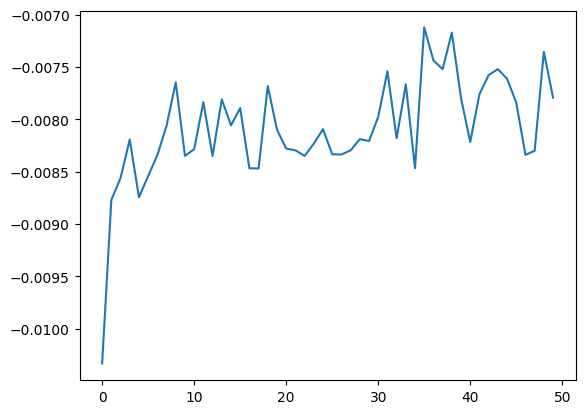

In [423]:
plt.plot(result_2)

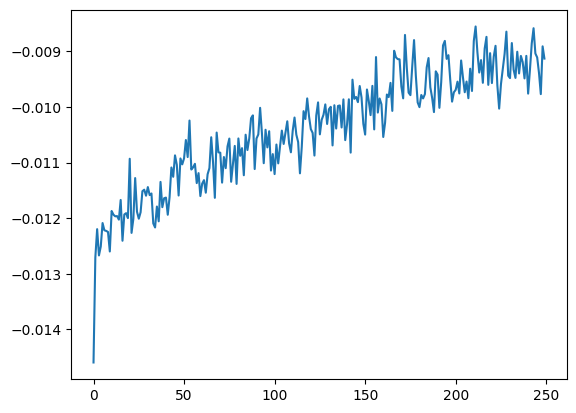

In [382]:
plt.plot(result)
# len(result)

In [272]:
test_architecture = AcesArchitectureEnv(52)

In [413]:
obs=test_architecture.reset()
action = algorithm_weights_restored.compute_single_action(obs)
test_architecture.step(action)

({'weights': array([0.0125, 0.001 , 0.02  , 0.5   ]),
  'allocation': array([0, 2, 5, 2, 3, 1, 3, 3, 6, 7, 2, 1, 4, 6, 5, 1, 1, 5, 5, 0, 2, 0,
         4, 7, 4, 5, 2, 5, 5, 5, 2, 5, 5, 0, 5, 4, 3, 6, 7, 5, 1, 2, 1, 0,
         6, 2, 1, 4, 2, 6, 2, 1], dtype=int32),
  'data_type': array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
         2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
         2, 2, 2, 2, 2, 2, 2, 2]),
  'free_space': array([0.98931, 0.97912, 0.19325, 0.2495 , 0.96325, 0.69675, 0.729  ,
         0.7395 ]),
  'last_calls_type': array([0, 1, 2, 3, 0, 1, 2, 0, 1, 2]),
  'last_calls_device': array([1, 1, 1, 0, 1, 1, 1, 1, 0, 4])},
 0.06415649978965088,
 True,
 {})

In [414]:
print(test_architecture.architecture.compute_total_latency())
print(1-test_architecture.architecture.compute_normalized_latency()-0.5)
print(np.std(test_architecture.free_space))
print("Reward: {}".format(1-np.std(test_architecture.free_space)))
test_architecture.architecture.greedy_algorithm()
print(test_architecture.architecture.compute_total_latency())
print(1-test_architecture.architecture.compute_normalized_latency()-0.5)
print(1-np.std(list(test_architecture.architecture.free_space().values())))

1036
0.06415649978965088
0.29423876894454276
Reward: 0.7057612310554573
Problem
It's ok
874
0.13230963399242746
0.8990616367529174


In [83]:
import ray
from ray.tune.registry import register_env
from gymnasium.wrappers import EnvCompatibility
from ray.rllib.algorithms.ppo import PPOConfig
from ray.rllib.algorithms.impala import ImpalaConfig
from gymnasium.wrappers import TimeLimit

ray.shutdown()

def env_creator(env_config):
    return TimeLimit(EnvCompatibility(AcesArchitectureEnv(52)), max_episode_steps=10)
register_env("AcesArchitectureEnv", env_creator)

config_whole = (
    ImpalaConfig()
    .environment("AcesArchitectureEnv",disable_env_checking=True)
    .rollouts(num_rollout_workers=30,
              num_envs_per_worker=5) # Max = 60
    .resources(num_gpus=0,
               num_cpus_per_worker=1)
    .training(entropy_coeff=0.02)
    # .offline_data(output="./TFM/datasets/impala_weights_20it")
)
config_whole["model"]["fcnet_hiddens"] = [256,256,256] # [256, 256] -> default
# print(config["model"]["fcnet_hiddens"])


algorithm_whole = config_whole.build()
algorithm_whole.set_weights(algorithm_weights.get_weights())
checkpoint_path = algorithm_whole.save()
print(checkpoint_path)
algorithm_whole = config_whole.build()
algorithm_whole.restore(checkpoint_path)

result_whole =[]
for i in tqdm(range(20)):
    train_result = algorithm_whole.train()["episode_reward_mean"]
    print(train_result)
    result_whole.append(train_result)
print(algorithm_whole)

2023-06-06 11:15:06,909	INFO worker.py:1553 -- Started a local Ray instance.
2023-06-06 11:15:27,543	INFO trainable.py:172 -- Trainable.setup took 23.500 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2023-06-06 11:15:27,546	WARNING util.py:67 -- Install gputil for GPU system monitoring.


/home/rcalzada/ray_results/Impala_AcesArchitectureEnv_2023-06-06_11-15-04l7okusgd/checkpoint_000000


2023-06-06 11:15:45,476	INFO trainable.py:172 -- Trainable.setup took 17.691 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2023-06-06 11:15:45,479	WARNING util.py:67 -- Install gputil for GPU system monitoring.
2023-06-06 11:15:45,961	INFO trainable.py:791 -- Restored on 138.4.11.227 from checkpoint: /home/rcalzada/ray_results/Impala_AcesArchitectureEnv_2023-06-06_11-15-04l7okusgd/checkpoint_000000
2023-06-06 11:15:45,963	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': None, '_time_total': 0.0, '_episodes_total': None}
  5%|█████▋                                                                                                            | 1/20 [00:14<04:44, 14.97s/it]

1.1442208844917199


 10%|███████████▍                                                                                                      | 2/20 [00:30<04:30, 15.01s/it]

1.16968643451961


 15%|█████████████████                                                                                                 | 3/20 [00:46<04:22, 15.46s/it]

1.14218284038133


 20%|██████████████████████▊                                                                                           | 4/20 [01:01<04:05, 15.36s/it]

1.1521464283475715


 25%|████████████████████████████▌                                                                                     | 5/20 [01:16<03:51, 15.41s/it]

1.1622031441469562


 30%|██████████████████████████████████▏                                                                               | 6/20 [01:32<03:35, 15.38s/it]

1.167257438358611


 35%|███████████████████████████████████████▉                                                                          | 7/20 [01:47<03:20, 15.46s/it]

1.1379632996710185


 40%|█████████████████████████████████████████████▌                                                                    | 8/20 [02:02<03:04, 15.41s/it]

1.1155598566632663


 45%|███████████████████████████████████████████████████▎                                                              | 9/20 [02:18<02:49, 15.42s/it]

1.131271686633538


 50%|████████████████████████████████████████████████████████▌                                                        | 10/20 [02:33<02:32, 15.24s/it]

1.1479758545987193


 55%|██████████████████████████████████████████████████████████████▏                                                  | 11/20 [02:47<02:15, 15.09s/it]

1.115153965023674


 60%|███████████████████████████████████████████████████████████████████▊                                             | 12/20 [03:02<02:00, 15.05s/it]

1.1191684487963085


 65%|█████████████████████████████████████████████████████████████████████████▍                                       | 13/20 [03:19<01:48, 15.47s/it]

1.1387431337431213


 70%|███████████████████████████████████████████████████████████████████████████████                                  | 14/20 [03:34<01:32, 15.45s/it]

1.1533014994293926


 75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 15/20 [03:49<01:16, 15.35s/it]

1.1500948492275016


 80%|██████████████████████████████████████████████████████████████████████████████████████████▍                      | 16/20 [04:05<01:01, 15.27s/it]

1.1577547870416434


 85%|████████████████████████████████████████████████████████████████████████████████████████████████                 | 17/20 [04:20<00:45, 15.31s/it]

1.1571176052934677


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 18/20 [04:35<00:30, 15.24s/it]

1.1411047521564832


Exception in thread Thread-663:
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/home/rcalzada/.local/lib/python3.10/site-packages/ray/rllib/execution/learner_thread.py", line 74, in run
    self.step()
  File "/home/rcalzada/.local/lib/python3.10/site-packages/ray/rllib/execution/multi_gpu_learner_thread.py", line 143, in step
    buffer_idx, released = self.ready_tower_stacks_buffer.get()
  File "/home/rcalzada/.local/lib/python3.10/site-packages/ray/rllib/execution/minibatch_buffer.py", line 48, in get
    self.buffers[self.idx] = self.inqueue.get(timeout=self.timeout)
  File "/usr/lib/python3.10/queue.py", line 179, in get
    raise Empty
_queue.Empty
 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 19/20 [04:50<00:15, 15.13s/it]

1.151451549908042


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [05:05<00:00, 15.29s/it]

1.1352486827219241
Impala


In [101]:
test_architecture = AcesArchitectureEnv(52)

In [116]:
action = algorithm_whole.compute_single_action(test_architecture.reset())
test_architecture.step(action)

({'weights': array([0.0125, 0.001 , 0.02  , 0.5   ]),
  'allocation': array([2, 1, 4, 0, 3, 3, 5, 4, 7, 4, 3, 6, 7, 2, 7, 6, 3, 0, 0, 0, 3, 6,
         1, 5, 7, 2, 2, 0, 1, 1, 1, 5, 4, 5, 6, 4, 1, 1, 4, 4, 1, 3, 4, 4,
         7, 1, 0, 0, 0, 0, 0, 0], dtype=int32),
  'data_type': array([3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
         0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
         2, 2, 3, 3, 3, 3, 3, 3]),
  'free_space': array([0.92855, 0.98839, 0.737  , 0.4695 , 0.708  , 0.99225, 0.979  ,
         0.97275]),
  'last_calls_type': array([ 0,  1,  2,  0,  1,  2, -1, -1, -1, -1]),
  'last_calls_device': array([ 4,  0,  6,  2,  7,  1, -1, -1, -1, -1])},
 1.246897148070211,
 True,
 {})

In [117]:
print(test_architecture.architecture.compute_total_latency())
# print(test_architecture.architecture.compute_normalized_latency())
# print(np.std(test_architecture.free_space))
# print("Reward: {}".format(1-test_architecture.architecture.compute_normalized_latency() + 1-np.std(test_architecture.free_space)))
test_architecture.architecture.greedy_algorithm()
print(test_architecture.architecture.compute_total_latency())
print(test_architecture.architecture.free_space().values())

828
Problem
It's ok
352
dict_values([0.93982, 0.9776, 0.96875, 0.75, 0.98125, 0.25, 0.9, 0.9965])
